# Notebook Setup

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm


from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout




import warnings
warnings.filterwarnings('ignore')

from user_functions import *

In [183]:
# Loading our dataset
df = pd.read_csv('data/zillow_data.csv')

# EDA

In [184]:
#Observing what our dataset looks like
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Data Analysis

## Narrowing the scope of our project

Our client is looking to purchase a home in Florida. We want to identify the best 5 Zip Codes which we believe will have the highest ROI after 3 years of purchase. i.e. We want the zipcodes that we believe will appreciate the most in value. These predictions will be mades using Time Series modeling.

### Looking at our Florida data

In [5]:
#Dataframe containing only zips from Florida
florida =  df[df['State']=='FL']

In [6]:
#Observing what our Florida dataset looks like
florida

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,111800.0,...,283500,286100,287800,288800,289700,291000,292500,294200,296400,298200
83,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0,126800.0,126800.0,...,297400,299300,301400,303300,304900,307100,309800,311700,312600,313100
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2917100,2925700,2942400,2958300,2946300,2912900,2900900,2923300,2933600,2914100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14250,73224,34797,Yalaha,FL,Orlando,Lake,14251,86100.0,86800.0,87400.0,...,174900,177100,179100,181500,184200,186200,187200,189000,191900,193500
14262,71852,32193,Welaka,FL,Palatka,Putnam,14263,53800.0,54100.0,54300.0,...,94400,99000,100800,101000,103000,105400,104900,106100,112600,118300
14315,72384,33051,Key Colony Beach,FL,Key West,Monroe,14316,202200.0,202800.0,203400.0,...,570200,564800,561100,557300,552300,545100,542300,551500,570900,585300
14558,72865,33855,Lake Wales,FL,Lakeland,Polk,14559,NaN,NaN,NaN,...,130400,131500,134800,137900,139400,140000,140000,140300,141900,143000


## Number of ZipCodes for each Metro in Florida

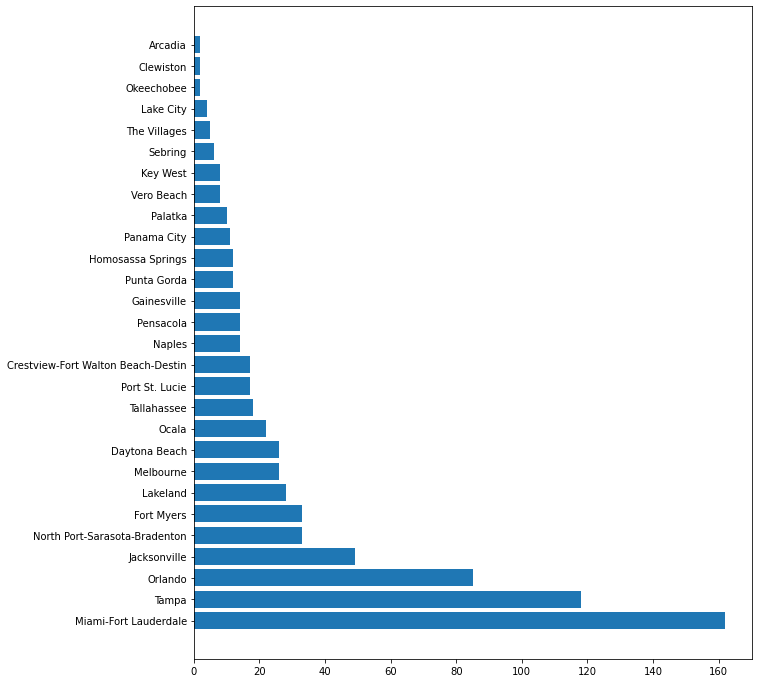

In [7]:
#Visualizing the value counts of zipcodes in each metro region in Florida

fig, ax = plt.subplots(figsize=(10,12))

y = [a for a in florida['Metro'].value_counts()]

x = [a for a in florida['Metro'].value_counts().keys()]

ax.barh(x,y);

We can see above that the Miami-Fort Lauderdale region has the highest number of zipcodes.

## Selecting a ZipCode to build our Time Series model on

We want to build a Time Series model to predict the future ROI for each zip code in Florida. But first, we will select one specific zipcode to build our time series model on. For this purpose, we decided to find the zipcode that has seen the highest growth in the 5 years since our last recorded date - April, 2018. i.e. We will find the zipcode which has grown the most between April,2015 and April,2018.

In [173]:
#Creating a new column that shows the 3 year increase in value. From April, 2015 to April, 2018.
florida['3 yr ROI'] = None
florida['3 yr ROI'] = florida['2018-04'].apply(lambda x : x-florida['2015-04'])

In [174]:
#Identifying the ZipCode that grew the most between April,2015 and April,2018.

roi_df = florida[['RegionName','3 yr ROI']].sort_values('3 yr ROI',ascending = False)

print(f'Highest growing Zipcode since April 2015 is : {int(roi_df.iloc[0][0])}')

Highest growing Zipcode since April 2015 is : 33480


We will run our first Time Series model on the ZipCode- 33480 to predict what its future value will be. Then we can run a similar model on other zipcodes in the state to identify which 5 zipcodes have the highest predicted ROI.

In [186]:
roi_df

,RegionName,3 yr ROI
4723,33480,4442100
84,33139,2670000
6391,33149,2627600
5746,34102,2471300
12634,33921,1745000
...,...,...
11786,32628,-171000
7087,33843,-172700
6841,32351,-173100
8476,32134,-180300


In [188]:
# Creating dataframes containing historical prices of the Top 5 Zip Codes
zip33480 = df[df['RegionName']==33480]
zip33139 = df[df['RegionName']==33139]
zip33149 = df[df['RegionName']==33149]
zip34102 = df[df['RegionName']==34102]
zip33921 = df[df['RegionName']==33921]

In [190]:
# Time Series dataframe of Top 5 Zip Code prices
series33480 = melt_data(zip33480)
series33139 = melt_data(zip33139)
series33149 = melt_data(zip33149)
series34102 = melt_data(zip34102)
series33921 = melt_data(zip33921)

In [191]:
# Creating a dataframe combining the information for the Top 5 Zip Codes
top5 = series33480.append([series33139, series33149, series34102, series33921])

In [192]:
top5

,value
time,
1996-04-01,958400.0
1996-05-01,958100.0
1996-06-01,957900.0
1996-07-01,957800.0
1996-08-01,958000.0
...,...
2017-12-01,1919700.0
2018-01-01,1926000.0
2018-02-01,1935800.0


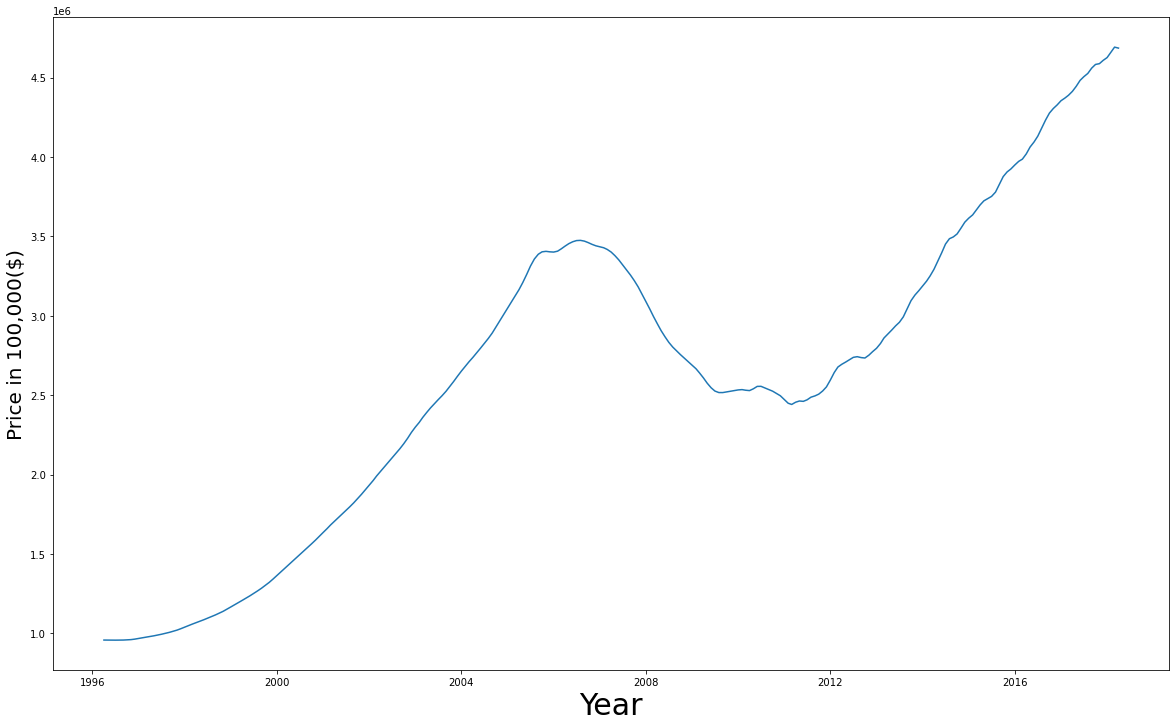

In [13]:
#Visualizing our Time Series Data
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series33480)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20);

We can see from above that after several years of growth in the early years of the 21st Century, prices seemed to have likely fallen due to the economic crisis that emerged in 2008. Since around 2011 though, there has been a dramatic increase in prices.

# Modeling

In [16]:
# def stationarity_check(TS):
    
#     # Import adfuller
#     from statsmodels.tsa.stattools import adfuller
    
#     # Calculate rolling statistics
#     roll_mean = TS.rolling(window=12, center=False).mean()
#     roll_std = TS.rolling(window=12, center=False).std()
    
#     # Perform the Dickey Fuller Test
#     dftest = adfuller(TS)
    
#     # Plot rolling statistics:
#     fig = plt.figure(figsize=(12,6))
#     plt.plot(TS, color='blue',label='Original')
#     plt.plot(roll_mean, color='red', label='Rolling Mean')
#     plt.plot(roll_std, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
#     # Print Dickey-Fuller test results
#     print('Results of Dickey-Fuller Test: \n')

#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
#                                              '#Lags Used', 'Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)
    
#     return None

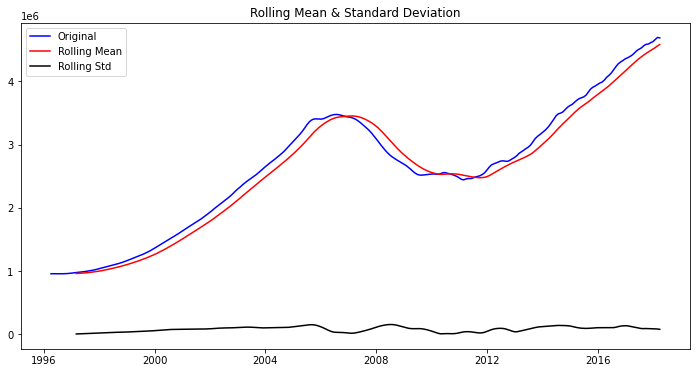

Results of Dickey-Fuller Test: 

Test Statistic                  -1.741387
p-value                          0.409925
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [17]:
stationarity_check(series33480)

In [32]:
data_diff = series33480.diff()

In [19]:
data_diff.head()

,value
time,
1996-04-01,NaN
1996-05-01,-300.0
1996-06-01,-200.0
1996-07-01,-100.0
1996-08-01,200.0


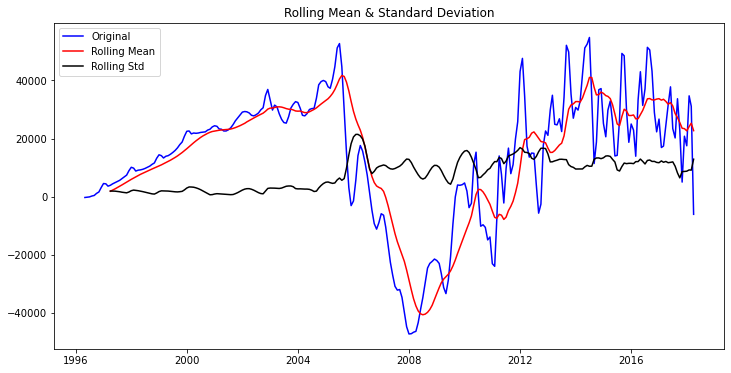

Results of Dickey-Fuller Test: 

Test Statistic                  -1.876634
p-value                          0.343132
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [21]:
stationarity_check(data_diff.dropna())

In [40]:
log_zip = np.log(series33480)

In [45]:
zip_diff = series33480.diff()

In [38]:
series_drop_nan = series33480.dropna()

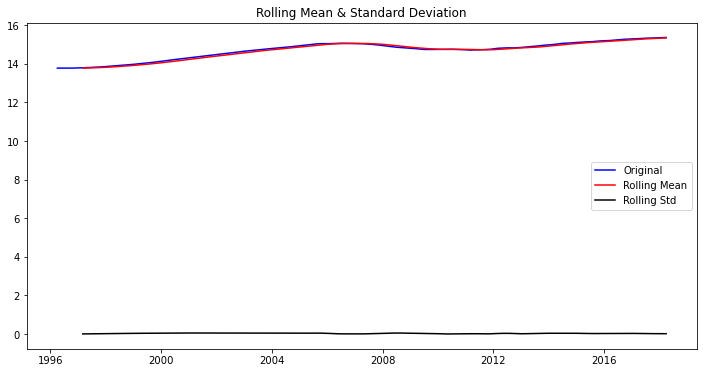

Results of Dickey-Fuller Test: 

Test Statistic                  -2.440318
p-value                          0.130679
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [41]:
stationarity_check(log_zip)

In [42]:
log_diff = log_zip.diff()

In [47]:
log_diff = log_diff.dropna()

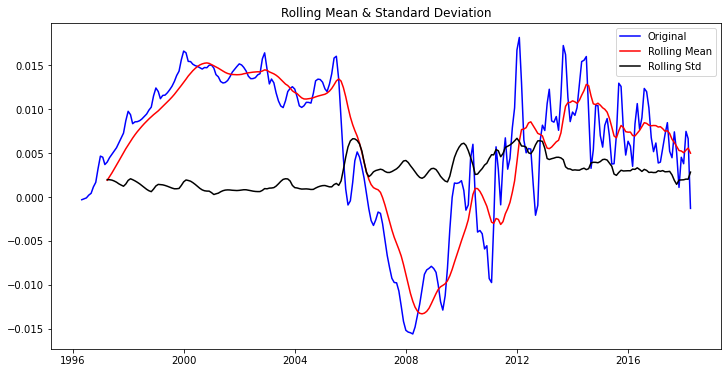

Results of Dickey-Fuller Test: 

Test Statistic                  -1.619108
p-value                          0.473197
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [44]:
stationarity_check(log_diff.dropna())

In [181]:
differencer(series33480)

0 nan
1 0.343131540861913
2 0.45148878461964975
3 0.3498779332973291
4 0.2657516719792066
5 0.2619961261754454
6 0.30968491386363906
7 0.19910839223251842
8 0.2115094850164156
9 0.37267840416752657
10 0.08902492361440495
11 0.14508366097604297
12 0.17102021265075695
13 0.06528026593849018
14 0.03683844039720054
15 0.028217511106596708
16 0.20034873851597862
17 0.39427111907187
18 0.3923268584409646
19 0.08066468289972795
20 0.15143785859299064
21 0.0324766436581636
22 0.0827926852867667
23 0.02497432287830202
24 0.03767554534847937


In [69]:
series_diff= series33480.diff(periods=14).dropna()

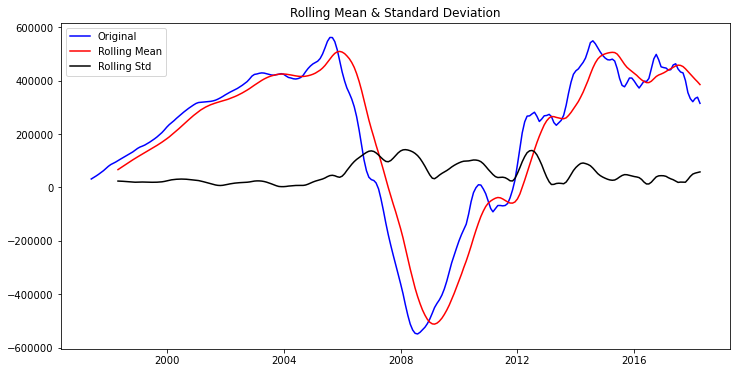

Results of Dickey-Fuller Test: 

Test Statistic                  -2.979656
p-value                          0.036838
#Lags Used                      15.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [71]:
# USE THIS ONE
stationarity_check(series_diff)

In [182]:
# Instantiate an AR(1) model to the simulated data
mod_arma = ARMA(series_diff, order=(1,0))

In [76]:
# # Fitting the model to data
# res_arma = mod_arma.fit()

In [77]:
# Finding the index which allows us to split off 20% of the data
cutoff = round(series_diff.shape[0]*0.8)
cutoff

201

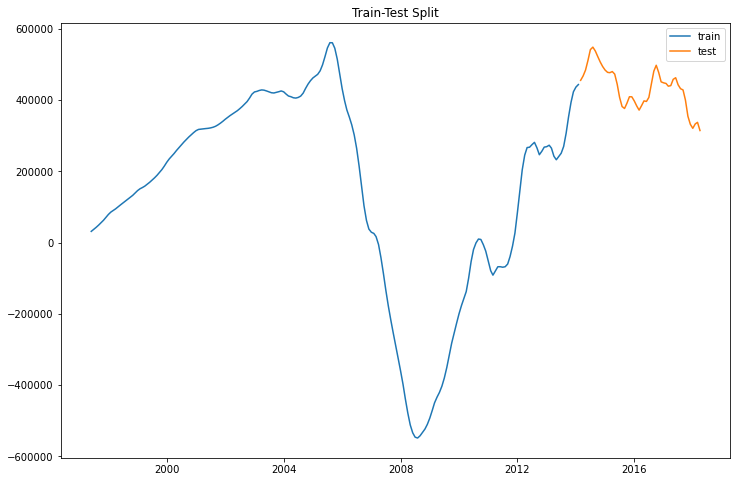

In [79]:
# Defining train and test sets according to the index found above
train = series_diff[:cutoff]
test = series_diff[cutoff:]

fix, ax = plt.subplots(figsize=(12,8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split')
plt.legend();

In [81]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68] [ 69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101] [102 103 104 105 106 107 1

Baseline

In [82]:
train

,value
time,
1997-06-01,31400.0
1997-07-01,36900.0
1997-08-01,42700.0
1997-09-01,49000.0
1997-10-01,55600.0
...,...
2013-10-01,352700.0
2013-11-01,393700.0
2013-12-01,423300.0


In [83]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

,value
time,
1997-06-01,NaN
1997-07-01,31400.0
1997-08-01,36900.0
1997-09-01,42700.0
1997-10-01,49000.0
...,...
2013-10-01,307100.0
2013-11-01,352700.0
2013-12-01,393700.0


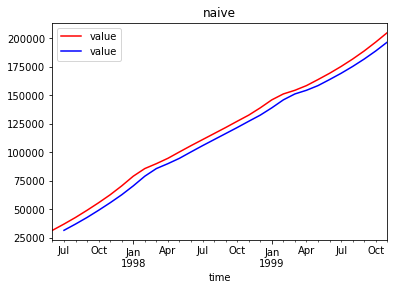

In [84]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [86]:
from sklearn.metrics import mean_squared_error


In [87]:
# Calculating RMSE for the naive model as a baseline to compare our later models

np.sqrt(mean_squared_error(train[1:], naive.dropna()))

20965.879423482336

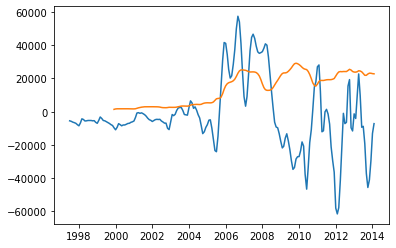

In [88]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

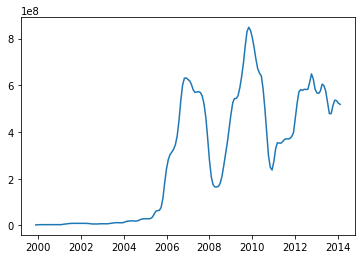

In [89]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

In [90]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline

In [91]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


1997-06-01         0.000000
1997-07-01     60456.844961
1997-08-01     42002.541071
1997-09-01     48080.861493
1997-10-01     54844.728863
                  ...      
2013-10-01    341611.732332
2013-11-01    395004.704149
2013-12-01    431737.124344
2014-01-01    450760.948307
2014-02-01    448553.325095
Freq: MS, Name: predicted_mean, Length: 201, dtype: float64

In [92]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  201
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2070.052
Date:                Tue, 24 Aug 2021   AIC                           4144.104
Time:                        14:32:56   BIC                           4150.701
Sample:                    06-01-1997   HQIC                          4146.774
                         - 02-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9277      0.020     46.578      0.000       0.889       0.967
sigma2      5.468e+07   1.36e-11   4.03e+18      0.000    5.47e+07    5.47e+07
===================================================================================
Ljung-Box (L1) (Q):                  54.12   Jarque-Bera (JB):                34.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.83   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [94]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  201
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2273.919
Date:                Tue, 24 Aug 2021   AIC                           4549.839
Time:                        14:33:47   BIC                           4553.137
Sample:                    06-01-1997   HQIC                          4551.173
                         - 02-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.374e+08   3.74e+07     11.687      0.000    3.64e+08    5.11e+08
===================================================================================
Ljung-Box (L1) (Q):                 177.57   Jarque-Bera (JB):                12.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.67   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 4549.838547357989
AR(1, 1, 0) AIC: 4144.104227726902


In [96]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

7863.503101132045

In [97]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


1997-06-01         0.000000
1997-07-01     60662.495177
1997-08-01     27381.012217
1997-09-01     48071.255785
1997-10-01     54933.277003
                  ...      
2013-10-01    350687.821102
2013-11-01    398363.170229
2013-12-01    427849.107603
2014-01-01    443361.783067
2014-02-01    438767.699472
Freq: MS, Name: predicted_mean, Length: 201, dtype: float64

In [98]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

4549.838547357989
4144.104227726902
4071.749518189915


In [99]:


y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

6703.550207708691

# Moving Average Model (MA)

In [100]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

1997-06-01    141732.835835
1997-07-01     86577.008418
1997-08-01    108625.424769
1997-09-01     92310.906665
1997-10-01    107104.052419
                  ...      
2013-10-01    236579.622732
2013-11-01    255597.910707
2013-12-01    277152.780356
2014-01-01    285041.752843
2014-02-01    290151.667762
Freq: MS, Name: predicted_mean, Length: 201, dtype: float64

In [102]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  201
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2736.513
Date:                Tue, 24 Aug 2021   AIC                           5479.026
Time:                        14:37:05   BIC                           5488.936
Sample:                    06-01-1997   HQIC                          5483.036
                         - 02-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.417e+05   9.28e+04      1.528      0.127   -4.01e+04    3.24e+05
ma.L1          0.9806      0.312      3.147      0.002       0.370       1.591
sigma2      8.136e+10      0.056   1.44e+12      0.000    8.14e+10    8.14e+10
===================================================================================
Ljung-Box (L1) (Q):                 201.21   Jarque-Bera (JB):                25.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.03   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+33. Standard errors may be unstable.
"""

In [103]:
# Looking at the 1st order MA model with a 1st order difference

ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

4549.838547357989
4144.104227726902
4071.749518189915
4302.2386755469215


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

In [105]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

11360.44652689901

In [107]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

1997-06-01         0.000000
1997-07-01     53512.262571
1997-08-01     27369.277242
1997-09-01     52033.903240
1997-10-01     55784.870943
                  ...      
2013-10-01    325872.574045
2013-11-01    393956.450224
2013-12-01    419902.687690
2014-01-01    427751.299815
2014-02-01    451741.875558
Freq: MS, Name: predicted_mean, Length: 201, dtype: float64

In [108]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

4549.838547357989
4144.104227726902
4071.749518189915
4302.2386755469215
4176.413096513015


# ARMA

In [109]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [110]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

4549.838547357989
4144.104227726902
4071.749518189915
4302.2386755469215
4176.413096513015
3989.5490784756535


In [111]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [112]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

21030.60787665662
7863.503101132045
6703.550207708691
11360.44652689901
8402.085657532916
5654.923031270215


# SARIMA

In [114]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [115]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:3481.3619364874994


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:2221.923680092454


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:2254.2613118961217


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:2223.6158964507495


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:3333.549419223009


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:2144.3592414021587


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:2191.4460737326326


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:2145.4104814073467


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:3110.7637029726047


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:2023.3959379818061


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:2030.724794444211


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:2024.8688748823372


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:3015.6764704090956


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:1960.102199618566


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:1985.0871204383668


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:1962.0849811503663


In [116]:
sari_mod =SARIMAX(train,
                  order=(1, 1, 1),
                  seasonal_order=(1, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [118]:
train_with_ind = train.reset_index()

In [120]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(1, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


48594.62046407132


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


87788.35437354243


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


442689.84668932843


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


378258.37807777827


/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


470481.08171295625


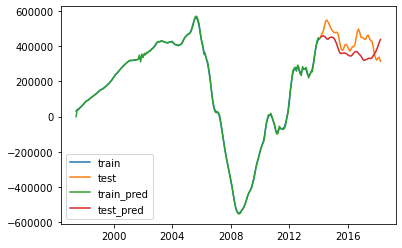

In [122]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

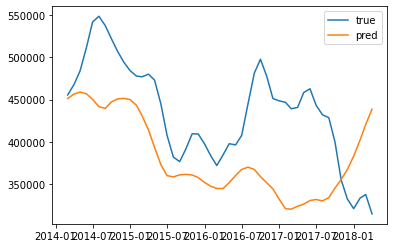

In [123]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [125]:
np.sqrt(mean_squared_error(test, y_hat_test))

78556.2402648046

# Forecasting

In [128]:
sari_mod = SARIMAX(series_diff,
                  order=(1, 1, 1),
                  seasonal_order=(1, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/a_conte/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [129]:
forecast = sari_mod.forecast(steps=52)

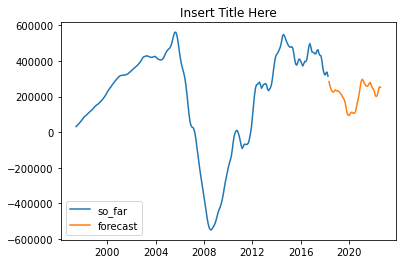

In [133]:
fig, ax = plt.subplots()
ax.plot(series_diff, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Insert Title Here')

plt.legend();

# LSTM(RNN)

In [135]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [138]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [139]:
# How many periods looking back to learn
n_per_in  = 90

# How many periods to predict
n_per_out = 30

# Features 
n_features = series_diff.shape[1]

# Splitting the data into appropriate sequences
X, y = split_sequence(series_diff.to_numpy(), n_per_in, n_per_out)

In [140]:
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=2, 
            n_nodes=30, 
            activation=activ,
            drop=1,
            d_rate=.1)

# Final Hidden layer
model.add(LSTM(90, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 90)            33120     
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 30)            14520     
_________________________________________________________________
dropout (Dropout)            (None, 90, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 90)                43560     
_________________________________________________________________
dense (Dense)                (None, 30)               

In [141]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [142]:
res = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
4/4 [==============================] - 2s 457ms/step - loss: 114500427776.0000 - accuracy: 0.1780 - val_loss: 182457499648.0000 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 1s 144ms/step - loss: 114500395008.0000 - accuracy: 0.1949 - val_loss: 182457303040.0000 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 1s 146ms/step - loss: 114500272128.0000 - accuracy: 0.1695 - val_loss: 182456795136.0000 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 1s 161ms/step - loss: 114500075520.0000 - accuracy: 0.1441 - val_loss: 182456369152.0000 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 1s 143ms/step - loss: 114499895296.0000 - accuracy: 0.1949 - val_loss: 182455943168.0000 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 1s 199ms/step - loss: 114499715072.0000 - accuracy: 0.1695 - val_loss: 182455484416.0000 - val_accuracy: 0.0000e+0

In [144]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

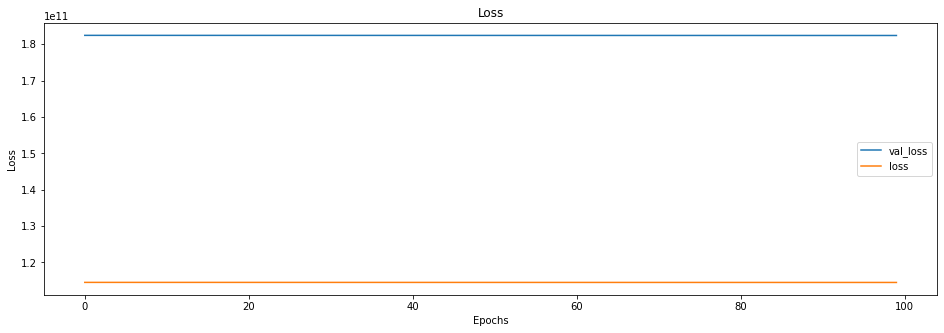

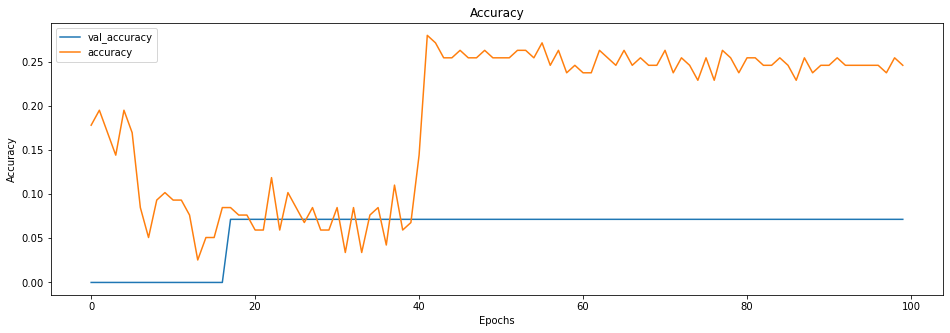

In [145]:
visualize_training_results(res)